# Exercise 8: Convolutional Neural Networks

$\renewcommand{\real}{\mathbb{R}}$
$\renewcommand{\xb}{\mathbf{x}}$
$\renewcommand{\yb}{\mathbf{y}}$
$\renewcommand{\zb}{\mathbf{z}}$
$\renewcommand{\wb}{\mathbf{w}}$
$\renewcommand{\Xb}{\mathbf{X}}$
$\renewcommand{\Lb}{\mathbf{L}}$
$\DeclareMathOperator*{\argmin}{argmin}$

Welcome to the 8th practical session of CS233 - Introduction to Machine Learning.

Today we will practice performing convolution on images, followed by implementing our own CNN with PyTorch. 


## Dependencies

Before you start, please make sure to install the following packages:

**torch**: The framework we will use for training deep nets.

**torchvision**: Helper package consisting of popular datasets, model architectures, and common image transformations for computer vision. We will use it for loading MNIST dataset and simple data transformations.

**torchsummary**: Helper package for visualizing deep net architectures.

Please use the following command to install all the dependencies:

`pip3 install torch torchvision torchsummary`

In [11]:
# 3rd party
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Lambda, Compose
from torchsummary import summary
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

# Project files.
from helpers import accuracy, DrawingPad, visualize_convolution, load_blackwhite_image

In [12]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
device = torch.device(('cpu', 'cuda')[torch.cuda.is_available()])

## Part 1: Convolution

### 1.1: Introduction: 1-D Convolution

Let's remember the definition of the convolution operation.

$$ y[i] = \sum_{m=- \infty}^{\infty} x[m] \cdot h[i-m] $$

We notice that the steps for convolution in this case are the following:
* We flip our filter $h[m]$ so that it becomes $h[-m]$.
* We shift $h[-m]$ to index $i$ so that it becomes $h[i-m]$.
* Multiply the two arrays $x[m]$ and $h[i-m]$ and sum over all values of $m$.
* As we calculate this for each index $i$, we are sliding filter $h[m]$ over $x[m]$ and repeating the steps above.

Consider the input array $x$ and filter $h$ given below:
$$x = [2,2,2,2,2,2,2,10,10,10,10,10,1,1,1,1,1,1,1,1,5,5,5,5,5] \\
h = [1, 0, -1]$$

Note that the filter is centered at index 0 ($h[-1]=1, h[0]=0, h[1]=1$)

Let's plot them to see what they look like:

In [14]:
x = np.array([2,2,2,2,2,2,2,10,10,10,10,10,1,1,1,1,1,1,1,1,5,5,5,5,5])
h = np.array([-1,0,1])

<IPython.core.display.Javascript object>


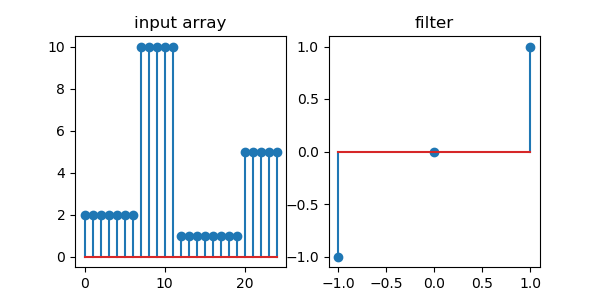

Text(0.5, 1.0, 'filter')

In [15]:
plt.figure(figsize=(6, 3))
plt.subplot(1,2,1)
plt.stem(x)
plt.title("input array")

plt.subplot(1,2,2)
plt.stem(range(-1,2), h)
plt.title("filter")

Below we have a visual explanation of convolution. 
Typing `q` into the input bar will quit the visualization.

<IPython.core.display.Javascript object>


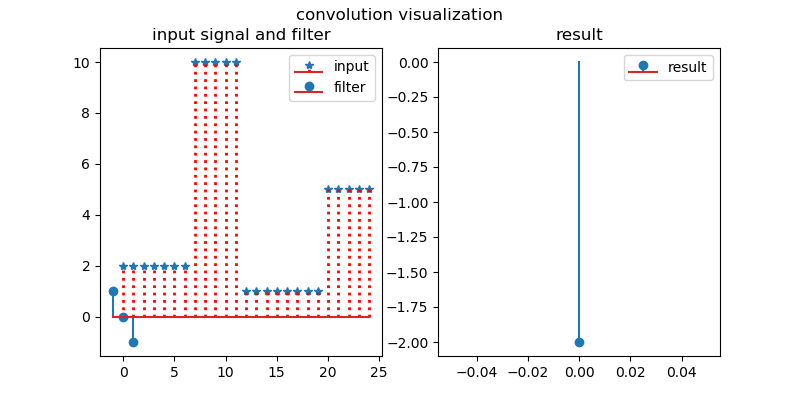

q


In [16]:
visualize_convolution()

**Q:** Calculate the output of the convolution operation by hand (you can do so for the first few elements of the result until you get the hang of it).



Notice that to calculate $y[0]$ you need the element $x[-1]$. A way to overcome this problem is to pad the input array with 0's. We pad both the beginning and the end of the array by `M//2` where $M$ denotes the filter size. The function to do padding for 1D arrays is given below.

In [17]:
#function to add zero padding to input array
def add_padding_1d(x, filter_size):
    """
    Adds zero padding to a 1-d array.
    Args:
        x (np.array): Input array.
        filter_size (int): size of the filter used in convolution
    Returns:
        np.array: resulting zero padded array.
    """
    
    return np.concatenate([np.zeros([filter_size//2,]), x, np.zeros([filter_size//2,])])

Fill in the convolution function given below.

In [18]:
#function to compute 1-D convolution
def convolution_one_dimensional(x, h):
    """
    1-d convolution
    Args:
        x (np.array): Input array.
        h (np.array): Filter
    Returns:
        np.array: convolution result
    """
    
    filter_size = h.shape[0]
    input_array_size = x.shape[0]
    
    #adding padding to input array
    x = add_padding_1d(x, filter_size)
    
    #flip kernel
    h = ... #your code here
    
    #slide kernel over input array 
    y = np.zeros(input_array_size)
    for i in range(input_array_size):
        y[i] = ... #Your code here
    return y

Run the code below to plot your result. We compare with numpy's `np.convolve()` function as a sanity check.

In [19]:
y = convolution_one_dimensional(x, h)
sanity_check = np.convolve(a=x,v=h,mode='same')
print("My result", y)
print("Numpy's result", sanity_check)

plt.figure()
plt.subplot(1,1,1)
markerline, stemlines, baseline = plt.stem(x, linefmt=':', markerfmt="*", label="input")
plt.setp(stemlines, color='r', linewidth=2)
plt.stem(y, label="result")
plt.title("result")
plt.legend()

TypeError: float() argument must be a string or a number, not 'ellipsis'

**Q:** Ignore the edge effects in the result above (these are caused by the padding). What is this filter doing? 


### 1.2: 2-D Convolution and Trying Different Image Filters

In a similar way, 2D convolution is defined as the following:

$$ y[i, j] = \sum_{m} \sum_{n} x[m, n] \cdot h[i-m, j-n] $$

In this case, we have 2D filters that we slide over our image. 

It's important to observe the effects of convolving images with different filters to get an idea of what our Convolutional Neural Networks learn to "see" in the images. 

Let's load an image to test some filters on.

In [ ]:
#true_logo = load_blackwhite_image(image_name="img/old_logo.png")
true_logo = load_blackwhite_image(image_name="img/new_logo.png")

plt.figure()
plt.imshow(true_logo, cmap='gray')

We will create some Gaussian filters and observe their effect on our images. 

**Q**: Run the code below and comment on what you see. What happens as we increase the  $\sigma$ value of the Gaussian?


In [ ]:
def gaussian_filter(sigma, filter_size):
    x = np.linspace(-1,1,filter_size)
    filter_one_d = np.exp(-0.5*(x/sigma)**2)
    filter_res = np.dot(filter_one_d[:,None], filter_one_d[:,None].T)
    filter_res = filter_res/np.sum(filter_res)
    return filter_res

#try different filters given below:
filter_1 = gaussian_filter(sigma=0.2, filter_size=8)
filter_2 = gaussian_filter(sigma=0.5, filter_size=8)
filter_3 = gaussian_filter(sigma=5, filter_size=8)

gaussian_filters = [filter_1, filter_2, filter_3]

In [ ]:
for ind, a_filter in enumerate(gaussian_filters):
    result = convolve2d(true_logo, a_filter, mode="same")

    #visualize filter and resulting image
    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.imshow(a_filter, cmap='gray')
    plt.title("filter "+ str(ind))
    plt.colorbar()
    
    plt.subplot(1,2,2)
    plt.imshow(result, cmap='gray')
    plt.colorbar()

Now let us create a horizontal and a vertical Sobel operator and convolve it with the image. 

Fill in the function below to threshold the image so that values below the average pixel value are set to 0 and the values above the average pixel value are set to 1. 

**Q**: What effects do you observe now? 
    

In [ ]:
filter_4 = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
filter_5 = filter_4.T

sobel_filters = [filter_4, filter_5]

for ind, a_filter in enumerate(sobel_filters):
    result = convolve2d(true_logo, a_filter, mode="same")

    plt.figure(figsize=(9, 3))
    
    #your code here
    thresholded_result = np.zeros(result.shape)
    thresholded_result ...

    #visualize filter and resulting image
    plt.subplot(1,3,1)
    plt.imshow(a_filter, cmap='gray')
    plt.title("filter "+ str(ind))
    plt.colorbar(fraction=0.046)
    
    plt.subplot(1,3,2)
    plt.imshow(result, cmap='gray')
    plt.title('result')
    plt.colorbar(fraction=0.04)
    
    plt.subplot(1,3,3)
    plt.imshow(thresholded_result, cmap='gray')
    plt.colorbar(fraction=0.046)
    plt.title('thresholded result')

## Part 2: PyTorch

### 2.1: Motivation

In the following part of the exercise we will revisit the MNIST dataset of hand-written digits from last week and we will train deep net models to classify the digits. Instead of doing all the hard coding work manually, we will simplify our life by using a deep learning framework PyTorch.

Last week we have implemented our own Multi-Layer Perceptron (MLP) where we defined both the feed-forward pass and back-propagation together with a simple optimizer (SGD update rule) and successfully trained it to perform the classification task. Given the amount of code written, one can imagine that prototyping with various NN architectures and training strategies might get tedious. That is where PyTorch (and other deep learning frameworks) come into play.

### 2.2: About PyTorch

[PyTorch](https://pytorch.org/) is an optimized tensor library for deep learning using GPUs and CPUs. It allows
for fast prototyping by providing high level access to all necessary building blocks including NN layers, activation functions, loss functions or optimizers to name a few. Most importantly, however, PyTorch implements the *[autograd](https://pytorch.org/docs/stable/autograd.html)* package which allows for automatic differentiation of the operations we use to define NN architectures. Put in other words, one only has to implement the forward pass, namely to combine desired layers, while the **backpropagation is computed automatically**.

### 2.3: Basic pipeline

In order to define and train deep net models, one would usually implement the following steps:

    1. Load the dataset.
    2. Define and instantiate a deep net architecture.
    3. Choose or implement a loss function (such as the mean squared error).
    4. Choose and instantiate an optimizer (such as the SGD).
    5. For each batch in the dataset:
        5.1. Load a batch.
        5.2. Run forward pass through your model.
        5.3. Compute the loss.
        5.4. Run backward pass of the loss w.r.t. the trainable parameters (weights).
        5.5. Update the weights using the optimizer.
        5.6. Zero-out the accumulated gradients before the next iteration.
        
We will see this exact pipeline in our code as well.

### 2.4: Essential bulding blocks

This section gives the high-level summary of the most important components representing the bare minimum which you will need to start playing with PyTorch and deep net models. You might want to skim through the official tutorials as well, namely [What is PyTorch](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py) and [Neural Networks](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py). Here is the list of the components which will be explained in more detail along with the code blocks.

  - **nn.Module**: Base class for NN architectures.
  - **criterion**: A loss function.
  - **backward-pass**: Derivatives computed by the auto-diff system.
  - **optimizer**: Updates the trainable parameters (weights) during training.


### 2.5: Loading the data

We are at the step (1) of the training pipeline. PyTorch provides us with the `Dataset` and `DataLoader` classes which manage the loading, shuffling and transformations of the data. Within our training loop we will treat our dataset as an *iterator* which returns the batches of data and associated labels.

As was the case of previous week, we will work with [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset where each sample is stored as $28 \times 28$ pixels grayscale image. The data are loaded as `torch.Tensor` data type.


In [ ]:
batch_size = 128

# Flattening transformation.
flatten = Lambda(lambda x: x.flatten())

# Dataset and DataLoader for MLP.
ds_fc_tr = MNIST('data', train=True, download=True, transform=Compose([ToTensor(), flatten]))
ds_fc_te = MNIST('data', train=False, download=True, transform=Compose([ToTensor(), flatten]))
dl_fc_tr = DataLoader(ds_fc_tr, batch_size=batch_size, shuffle=False, num_workers=1)
dl_fc_te = DataLoader(ds_fc_te, batch_size=batch_size, shuffle=False, num_workers=1)

# Dataset for CNN.
ds_cnn_tr = MNIST('data', train=True, download=True, transform=ToTensor())
ds_cnn_te = MNIST('data', train=False, download=True, transform=ToTensor())
dl_cnn_tr = DataLoader(ds_cnn_tr, batch_size=batch_size, shuffle=False, num_workers=5)
dl_cnn_te = DataLoader(ds_cnn_te, batch_size=batch_size, shuffle=False, num_workers=5)

ntr = len(ds_fc_tr)
nva = len(ds_fc_te)
print('Loaded {} tr and {} va samples.'.format(ntr, nva))

##### 2.6: Multi-Layer Perceptron (MLP)

#### Architecture

We are at step (2) of the training pipeline. We will start with implementing a MLP consisting of a 1D input layer (we flatten the input image) of shape ($784$, ), $3$ hidden fully connected layers and an output layer of shape ($10$, ), as we have $10$ classes. 

#### Optimization criterion

We would like to interpret the output vector $\zb \in \real^{10}$ as the probabilities of data sample $\xb \in \real^{784}$ belonging to each class $j \in \{1, 2, ... 10\}$. Therefore, we will make use of the activation function **softmax** defined as:

$$ P(\text{class}=j|\zb) = \frac{\exp{\zb^{\top}\wb_{j}}}{\sum_{k=1}^{K}{\exp{\zb^{\top}\wb_{k}}}}. $$

Let $\zb'$ be the predicted probability distribution with $\zb'_{j} = \text{softmax}_{j}(\zb)$. Softmax guarantees that $\sum_{k=1}^{K}{\zb'_{k}} = 1$, meaning that out predicted vector $\zb'$ is indeed a valid probability distribution over classes. 

Finally, we would like to match the predicted distribution $\zb'$ to the ground truth (GT) one $\yb$, where $\yb$ is given by one-hot encoding ($\yb$ is all zeros except $1$ at the index $j$, if $j$ is correct class to be predicted). The optimization criterion of choice is then to minimize the [**cross-entropy**](https://en.wikipedia.org/wiki/Cross_entropy) (CE) of $\zb'$ and $\yb$, therefore our final loss function $L$ is defined as:

$$ L = \text{CE}(\yb, \zb').$$

Thankfully, PyTorch has got us covered by providing the implementation of $L$, so you will only really need to provide the output $\zb$ (i.e. the 10-dimensional output of your last layer). We will get back to $L$ later.

---

#### nn.Module
Each custom NN architecture you choose to implement has to subclass the [`nn.Module`](https://pytorch.org/docs/stable/nn.html#module) which conveniently keeps track of all the trainable parameters. From the programmer perspective, you have to implement the constructor (`__init__`) and override the `forward()` function:

- **\_\_init__()**

You will define your layers (e.g. fully connected layer, 2D convolutional layer, etc.) in the constructor and `nn.Module` will automatically keep track of all the weights these layers contain.

- **forward()**

This function really defines the architecture, as you will sequentally call your layers in the desired order. Each time you call `forward()` (every training iteration), the so called **computational graph** is built. It is a directed acyclic graph (DAG) of nodes corresponding to the operations you have called. Each node defines the derivative of its outputs w.r.t. its inputs. The computational graph is then traversed in the reversed fashion once you call `backward()` and the derivatives are computed.

All the trainable parameters which your model consists of can be accessed via call to `model.parameters()` implemented in `nn.Module`. This comes in handy once instantiating your optimizer as you have to pass all the parameters you want it to manage.

---

Your task is to define the MLP as depicted on the figure below. Please refer to the documentation and focus on
the classes `nn.Linear` to define the layers and `F.relu` to call the activation funtion.

<img src="img/mlp.png" width=800></img>


In [ ]:
class FC(nn.Module):
    """ Standard Multi layer perceptron for classification into 10 classes,
    3 FC layers, ReLU activations for the first 2.
    """
    def __init__(self):
        """ Constructor, layer definition goes here. Only specify
        those layers which have any trainable parameters (but for
        instance not the activation functions as the ones we use 
        do not have any trainable parameters). """
        super(FC, self).__init__()

        #Your code here
        self._fc1 = ... 
        self._fc2 = ...
        self._fc3 = ...
        self._fc4 = ...

    def forward(self, x):
        """ Feed-forward pass, this is where the actual computation happens
        and the computational graph is built (from scratch each time this 
        function is called). """
        
        #Your code here
        return ...
    
# Instantiate the model.
model_fc = FC().to(device)

**Q:** What is the number of learnable parameters (weights) this model has?


### 2.7: Inspecting the model architecture

Let us check the model architecture and see how many trainable parameters we really use. For this purpose we will use `torchsummary` package.

Notice the number of trainable parameters.

In [ ]:
summary(model_fc, input_size=(28 * 28, ))

### 2.8: Loss function

We are at step (3) of our pipeline. As explained above, our loss function $L$ will be $\text{CE}(\yb, \zb')$, which is provided for us by PyTorch, please refer to the documentation of [`nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html?highlight=cross_entropy#torch.nn.CrossEntropyLoss).

There are [many commonly used loss functions](https://pytorch.org/docs/stable/nn.html#id51) defined in the `torch.nn` module and you can implement your own using PyTorch operations as well. 

Your task is to instantiate the CE loss function.

In [ ]:
# Define the loss fuction.
criterion = ... #your code here

### 2.9: Optimizer
We are at step (4) of the pipeline. [Optimizer](https://pytorch.org/docs/stable/optim.html) updates the weights given the currently computed gradients. It can be a simple state-less function (such as SGD) or one of more advanced ones which keep track of additional information about the weights and the gradients (such as a running mean) which can be used for smarter update rules.

We will opt for the simplest case, the state-less SGD. Your task is to instantiate this optimizer, please refer to [`optim.SGD`](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD).

In [ ]:
learning_rate = 1e-1
opt = ... #your code here

### 2.10: Training loop

We are at step (5) of our pipeline. We would like to define a training loop where we iterate over training samples and train our model. Let us define a function `train_model()` which will be used for training any architecture we come up with.

Fill in the code which follows the steps 5.2 - 5.6 of our training pipeline. For running the backward pass, use the function [`backward()`](https://pytorch.org/docs/stable/autograd.html?highlight=backward#torch.autograd.backward). For zeroing out the accumulated gradients, use the function [`zero_grad()`](https://pytorch.org/docs/stable/nn.html?highlight=zero_grad#torch.nn.Module.zero_grad).

In [ ]:
def train_model(model, crit, opt, dl_tr, dl_te, epochs):
    for ep in range(epochs):
        # Training.
        model.train()
        for it, batch in enumerate(dl_tr):
            # 5.1 Load a batch.
            x, y = [d.to(device) for d in batch]

            # 5.2 Run forward pass.
            logits = ... #your code here
            
            # 5.3 Compute loss (using 'criterion').
            loss = ... #your code here
            
            # 5.4 Run backward pass.
            #your code here
            
            # 5.5 Update the weights using optimizer.
            #your code here
            
            # 5.6 Zero-out the accumualted gradients.
            #your code here

            print('\rEp {}/{}, it {}/{}: loss train: {:.2f}, accuracy train: {:.2f}'.
                  format(ep + 1, epochs, it + 1, len(dl_tr), loss,
                         accuracy(logits, y)), end='')

        # Validation.
        model.eval()
        with torch.no_grad():
            acc_run = 0
            for it, batch in enumerate(dl_te):
                # Get batch of data.
                x, y = [d.to(device) for d in batch]
                curr_bs = x.shape[0]
                acc_run += accuracy(model(x), y) * curr_bs
            acc = acc_run / nva

            print(', accuracy test: {:.2f}'.format(acc))

### Training the model

In [ ]:
epochs = 5
train_model(model_fc, criterion, opt, dl_fc_tr, dl_fc_te, epochs)

## Part 3: Convolutional Neural Networks (CCNs)

Our 3 layered MLP network works well reaching test accuracy of ~0.96. However, this network uses ~0.5M weights. We can use even deeper architectures with less weights and take the advantage of the 2D structure of the input data (images) using CNNs.

### 3.1: LeNet-5

Let us define a simple CNN network of 2 convolutional layers with max-pooling and 3 FC layers. In particular, we will implement a variant of the architecture called [LeNet-5 introduced by Yann LeCun in 1999](http://yann.lecun.com/exdb/publis/pdf/lecun-99.pdf). 


Your task is to define a simple LeNet-5 architecture depicted in the figure below. Check the architecture using `torchsummary` and comment on the number of parameters. Finally train the model. To specify the layers, please refer to the functions [`Conv2d`](https://pytorch.org/docs/stable/nn.html#conv2d) and [`max_pool2d`](https://pytorch.org/docs/stable/nn.html?highlight=max_pool2d#torch.nn.functional.max_pool2d).

<img src="img/lenet5.png" width=800></img>



In [ ]:
class CNN_LeNet(nn.Module):
    """ CNN, expects input shape (28, 28).
    """
    def __init__(self):
        super(CNN_LeNet, self).__init__()

        #your code here
        self._conv2d1 = ...
        self._conv2d2 = ...
        self._fc1 = ...
        self._fc2 = ...
        self._fc3 = ...

    def forward(self, x):
        #your code here
        return ...
    
# Instantiate the model.
model_lenet = CNN_LeNet().to(device)

**Q:** What is the number of trainable parameters in our LeNet model?

Let us check the architecture again and the number of trainable parameters. We can directly see that this architecture needs just about 20% of the parameters the MLP used.

In [ ]:
# Print out the architecture and check the number of parameters.
summary(model_lenet, input_size=(1, 28, 28))

In [ ]:
# Train the model
epochs = 5
opt_lenet = torch.optim.SGD(model_lenet.parameters(), lr=learning_rate)
train_model(model_lenet, F.cross_entropy, opt_lenet, dl_cnn_tr, dl_cnn_te, epochs)

### 3.2: 3-layered CNN

Let us now define even deeper CNN with 3 convolutional layers and only 2 FC layers. This network should reach higher accuracy (or converge faster) and still use less parameters than the previous architectures.

Your task is to implement a 3 layered CNN as depicted in the figure below. Check the number of parameters using `torchsummary`. Train the model and play around with the number of filters (kernels) which are used by every layer. Comment on your findings.

<img src="img/cnn.png" width=800></img>

In [ ]:
class CNN(nn.Module):
    """ CNN, expects input shape (28, 28).
    """
    def __init__(self, filters=(16, 32, 64)):
        super(CNN, self).__init__()

        self._conv2d1 = nn.Conv2d(1, filters[0], 3, 1, padding=1)
        self._conv2d2 = nn.Conv2d(filters[0], filters[1], 3, 1, padding=1)
        self._conv2d3 = nn.Conv2d(filters[1], filters[2], 3, 1, padding=1)
        self._fc1 = nn.Linear(3 * 3 * filters[2], 128)
        self._fc2 = nn.Linear(128, 10)

    def forward(self, x):
        #your code here
        return ...

# Instantiate the model.
filters = [16, 32, 64]
model_cnn = CNN(filters).to(device)

In [ ]:
# Print out the architecture and number of parameters.
summary(model_cnn, input_size=(1, 28, 28))

In [ ]:
# Train the model.
opt_cnn = torch.optim.SGD(model_cnn.parameters(), lr=learning_rate)
train_model(model_cnn, F.cross_entropy, opt_cnn, dl_cnn_tr, dl_cnn_te, epochs)

### 3.3: Trying out your own input

We have provided a tool for you to draw your own digits and test your network. Play around with the inputs to get a sense of how accurate your model is!

In [ ]:
dp = DrawingPad((28, 28), (10, 10))

In [ ]:
gr = dp.grid
inp = torch.from_numpy(gr).to(device)[None, None]
pred = model_lenet(inp)
clp = torch.argmax(pred)
print("Your prediction:", clp.item())